In [2]:
from biopandas.pdb import PandasPdb
import mdtraj as md
import urllib, tarfile, requests
import re, os, glob
from os import listdir
from os.path import isfile, join

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

cwd = os.getcwd()

### Initia DataSet (PDB) Exploration Task : 01/27
- 'PSF-PDB_spike_open_prot_glyc_memb_wat_ions_amarolab.tar.gz'
- 'PSF-PDB_spike_closed_prot_glyc_memb_wat_ions_amarolab.tar.gz'

#### Auto-download and extract pdb from  DataSet from "https://amarolab.ucsd.edu/files/covid19"

In [3]:
def download_n_extract_4m_url(filNames, url="https://amarolab.ucsd.edu/files/covid19", extract_dir = "amarolab_covid19"):
    outDir_dict = {}
    if not os.path.exists(extract_dir) :
        os.mkdir(extract_dir)
        
    for tarF in filNames :
        out_dir = extract_dir + '/' + str(os.path.basename(tarF)).split('.')[0]
        
        if not os.path.exists(out_dir) :
            os.mkdir(out_dir)
        out_file = out_dir + '/' + tarF
        if not os.path.exists(out_file) :
            print(f'Downloading {tarF} from {url} at  {out_file}')
            zip_path, _ = urllib.request.urlretrieve(url + '/' + tarF, out_file)
            with tarfile.open(name=zip_path, mode="r") as tf:
                print(f'Extracting {out_file} : {tf.getnames()}')
                outDir_dict[out_dir]  = tf.getnames()
                tf.extractall(out_dir)
        else :
            print(f' {out_file} already exists locally')
            outDir_dict[out_dir] = [os.path.join(out_dir, f) for f in os.listdir(out_dir) if os.path.isfile(os.path.join(out_dir, f))]
            
    return outDir_dict

def get_ext_4m_diskData(ext='pdb'):
    return {dir_key:glob.glob((dir_key + '/*' + ext)) for dir_key in  data_on_disk_dict.keys()}

In [4]:
data_on_disk_dict = download_n_extract_4m_url(['PSF-PDB_spike_open_prot_glyc_memb_wat_ions_amarolab.tar.gz','PSF-PDB_spike_closed_prot_glyc_memb_wat_ions_amarolab.tar.gz'])

 amarolab_covid19/PSF-PDB_spike_open_prot_glyc_memb_wat_ions_amarolab/PSF-PDB_spike_open_prot_glyc_memb_wat_ions_amarolab.tar.gz already exists locally
 amarolab_covid19/PSF-PDB_spike_closed_prot_glyc_memb_wat_ions_amarolab/PSF-PDB_spike_closed_prot_glyc_memb_wat_ions_amarolab.tar.gz already exists locally


In [5]:
pdb_dict = get_ext_4m_diskData()    
pdbs = [pdb_dict[p][0] for p in sorted(list(pdb_dict.keys()))]

In [6]:
closed_pdb = PandasPdb().read_pdb(pdbs[0])

In [7]:
closed_pdb_df = closed_pdb.df['ATOM']

In [8]:
closed_pdb_df.head()

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,NaN,,N,,SER,,A,13,,...,-27.011,75.877,185.141,0.0,0.0,,AS1,,NaN,1
1,ATOM,NaN,,HT1,,SER,,A,13,,...,-26.798,74.892,185.397,0.0,0.0,,AS1,,NaN,2
2,ATOM,NaN,,HT2,,SER,,A,13,,...,-26.212,76.103,184.514,0.0,0.0,,AS1,,NaN,3
3,ATOM,NaN,,HT3,,SER,,A,13,,...,-27.835,75.987,184.516,0.0,0.0,,AS1,,NaN,4
4,ATOM,NaN,,CA,,SER,,A,13,,...,-27.179,76.733,186.337,0.0,0.0,,AS1,,NaN,5


In [9]:
def cleanup_df(dfx) :
    return (dfx
    # drop columns with all enteries = NaN
     .loc[ :, lambda df : [c for c in df.columns.to_list() if df[c].isna().sum() < df.shape[0]]]
    # drop columns with all enteries = empty string
     .loc[ :, lambda df : [c for c in df.columns.to_list() if np.all(df[c].astype(str).str.extract(r'(\S+)').isna().sum() < df.shape[0])] ]
    # drop columns with all enteries are same. Its redundant columns, no useful Info
     .loc[ :, lambda df : [x for x in df.columns.to_list() if len(df[x].value_counts()) > 1]]
     .drop(['line_idx'],axis=1)
    )

In [10]:
closed_pdb_prep_df = cleanup_df(closed_pdb_df)

- dropped redundant columns capturing no Info
- column blank_2 is prtially empty ?

In [11]:
closed_pdb_prep_df.head()

,atom_name,residue_name,blank_2,chain_id,residue_number,x_coord,y_coord,z_coord,segment_id
0,N,SER,,A,13,-27.011,75.877,185.141,AS1
1,HT1,SER,,A,13,-26.798,74.892,185.397,AS1
2,HT2,SER,,A,13,-26.212,76.103,184.514,AS1
3,HT3,SER,,A,13,-27.835,75.987,184.516,AS1
4,CA,SER,,A,13,-27.179,76.733,186.337,AS1


In [12]:
closed_pdb_prep_df.describe(include='all')

,atom_name,residue_name,blank_2,chain_id,residue_number,x_coord,y_coord,z_coord,segment_id
count,1658914,1658914,1658914,1658914,1.658914e+06,1.658914e+06,1.658914e+06,1.658914e+06,1658914
unique,316,34,10,7,NaN,NaN,NaN,NaN,79
top,H1,TIP,3,W,NaN,NaN,NaN,NaN,WAT
freq,473236,1417533,1417533,1417533,NaN,NaN,NaN,NaN,1417533
mean,NaN,NaN,NaN,NaN,9.134314e+02,-5.279541e-01,9.723637e-01,1.158889e+02,NaN
std,NaN,NaN,NaN,NaN,5.469105e+02,5.846553e+01,5.809634e+01,1.153228e+02,NaN
min,NaN,NaN,NaN,NaN,1.000000e+00,-1.180870e+02,-1.091680e+02,-8.385200e+01,NaN
25%,NaN,NaN,NaN,NaN,4.420000e+02,-5.103775e+01,-4.919500e+01,1.494700e+01,NaN
50%,NaN,NaN,NaN,NaN,9.020000e+02,-5.140000e-01,9.140000e-01,1.157365e+02,NaN
75%,NaN,NaN,NaN,NaN,1.362000e+03,4.997400e+01,5.118500e+01,2.157297e+02,NaN


In [13]:
print(f'INFO: Unique Chain ids : {closed_pdb_prep_df.chain_id.unique()}')
def get_df_4_chain(dfx) :
    chain_dict_df_pointer = {}
    for ch in dfx.chain_id.unique():
        chain_dict_df_pointer[ch] = dfx[dfx.chain_id == ch]
        print(f'INFO: Number of data points for Chain#{ch} : {dfx[dfx.chain_id == ch].shape[0]}')
    return chain_dict_df_pointer

INFO: Unique Chain ids : ['A' 'B' 'C' 'G' 'M' 'W' 'I']


#### Different # of data points/atoms across chains


In [14]:
pdb_chain_dict_df_pointer = get_df_4_chain(closed_pdb_prep_df)

INFO: Number of data points for Chain#A : 19544
INFO: Number of data points for Chain#B : 19545
INFO: Number of data points for Chain#C : 19545
INFO: Number of data points for Chain#G : 14236
INFO: Number of data points for Chain#M : 165561
INFO: Number of data points for Chain#W : 1417533
INFO: Number of data points for Chain#I : 2950


In [556]:
def rpt_unique_vals_4_col(df_dict,col):
    out_df = pd.DataFrame()
    for c in df_dict.keys():
        out_df = (out_df
                  .append(pd.DataFrame( np.ones(shape=(1,len(df_dict[c][col].unique()) ) ), columns=df_dict[c][col].unique() )
                          .assign(id_chain = c)
                          .assign(count_of_residue_types = lambda df : df.sum(axis=1).astype(int))
                          .assign(countOfAtomTypes =  len(df_dict[c]["atom_name"].unique()))
                          .assign(countOfDataPoints =  df_dict[c].shape[0])
                          )
                 )
        
    return out_df[sorted(out_df.columns.to_list(),reverse=True)].fillna(0)
db_df = rpt_unique_vals_4_col(pdb_chain_dict_df_pointer,'residue_name')
db_df.drop(['countOfAtomTypes'],axis=1).reset_index(drop=True)

<ipython-input-556-d594d378a463>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  .assign(count_of_residue_types = lambda df : df.sum(axis=1).astype(int))


,id_chain,count_of_residue_types,countOfDataPoints,VAL,TYR,TRP,TIP,THR,SOD,SER,...,BGL,BGA,ASP,ASN,ARG,ANE,AMA,ALA,AGA,AFU
0,A,22,19544,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,B,22,19545,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,C,22,19545,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,G,7,14236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
4,M,2,165561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,W,1,1417533,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,I,2,2950,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [557]:
db_df.loc[:,['id_chain','count_of_residue_types','countOfAtomTypes','countOfDataPoints']].reset_index(drop=True)

,id_chain,count_of_residue_types,countOfAtomTypes,countOfDataPoints
0,A,22,131,19544
1,B,22,131,19545
2,C,22,131,19545
3,G,7,49,14236
4,M,2,205,165561
5,W,1,3,1417533
6,I,2,2,2950


### Review x/y/z displacement trends across all chains

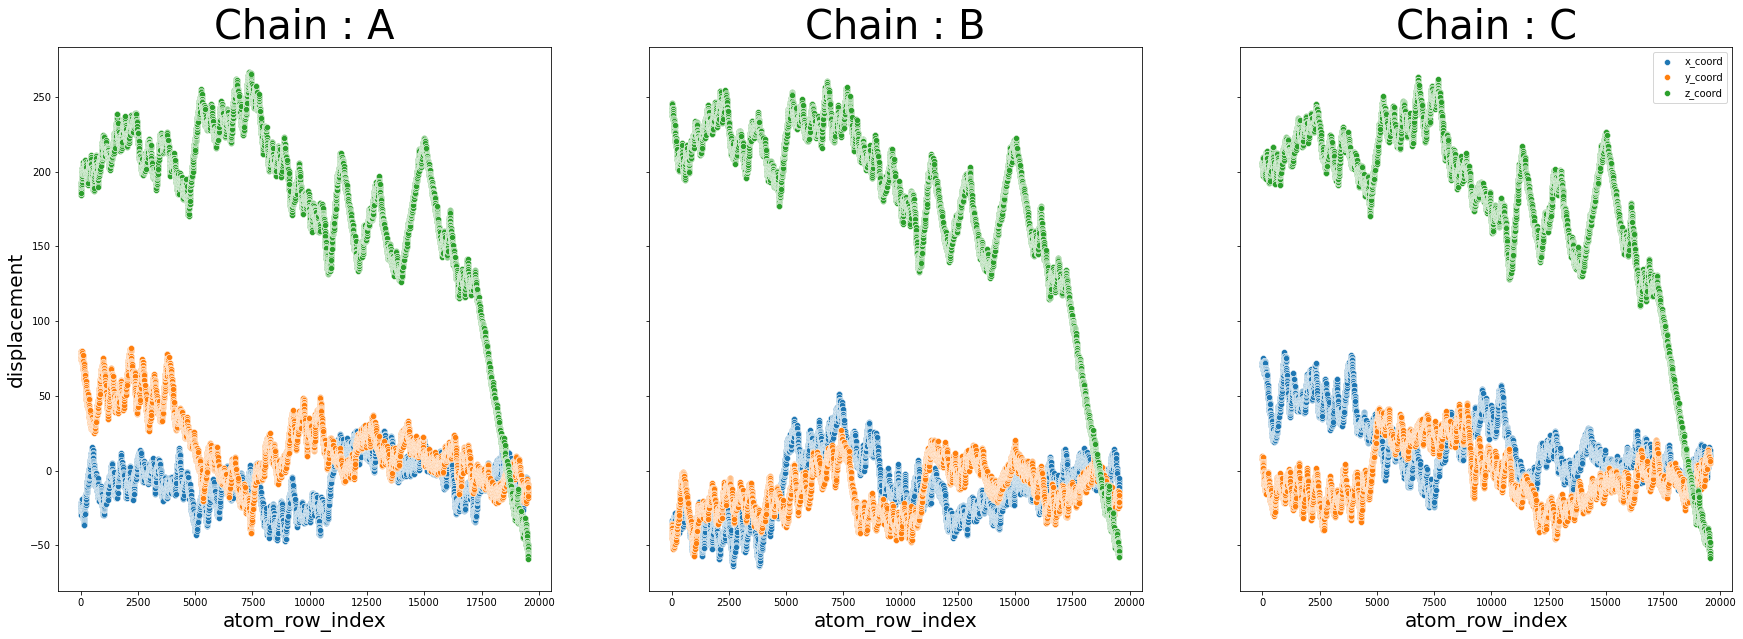

In [15]:
chain_keys = closed_pdb_prep_df.chain_id.unique()
ncol = 3
nrow = 1
fig, ax = plt.subplots(ncols=3,nrows=nrow,figsize=(30,10),sharex=False,sharey=True)
for i in range(3) :
    row_id = i 
    cur_chain_key = chain_keys[i]
    sns.scatterplot(data = pdb_chain_dict_df_pointer[cur_chain_key], y = 'x_coord' , x = [i for i in range(pdb_chain_dict_df_pointer[cur_chain_key].shape[0])],ax = ax[row_id])
    sns.scatterplot(data = pdb_chain_dict_df_pointer[cur_chain_key], y = 'y_coord' , x = [i for i in range(pdb_chain_dict_df_pointer[cur_chain_key].shape[0])],ax = ax[row_id])
    sns.scatterplot(data = pdb_chain_dict_df_pointer[cur_chain_key], y = 'z_coord' , x = [i for i in range(pdb_chain_dict_df_pointer[cur_chain_key].shape[0])],ax = ax[row_id])
    ax[row_id].set_xlabel('atom_row_index', fontsize=20)
    ax[row_id].set_ylabel('displacement' , fontsize=20, rotation=90)
    ax[row_id].set_title(f'Chain : {cur_chain_key}', fontsize=40)
    plt.legend(labels=['x_coord','y_coord','z_coord'])
plt.show()

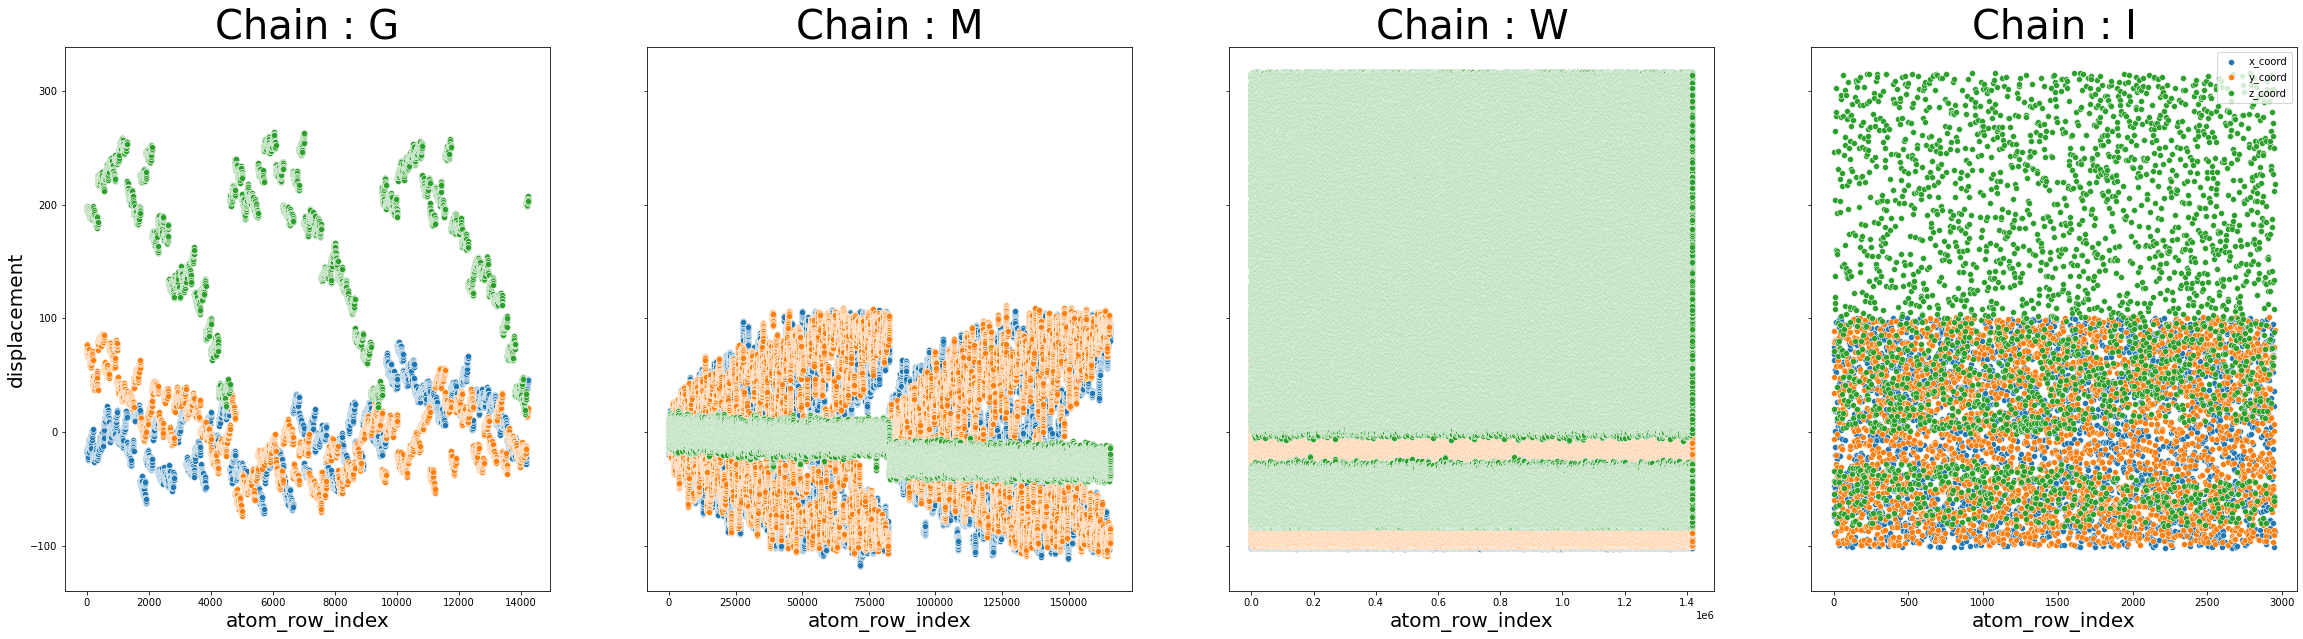

In [16]:
chain_keys = closed_pdb_prep_df.chain_id.unique()
ncol = 4
nrow = 1
fig, ax = plt.subplots(ncols=4,nrows=nrow,figsize=(40,10),sharex=False,sharey=True)
for i in range(3,7) :
    row_id = i - 3 
    cur_chain_key = chain_keys[i]
    sns.scatterplot(data = pdb_chain_dict_df_pointer[cur_chain_key], y = 'x_coord' , x = [i for i in range(pdb_chain_dict_df_pointer[cur_chain_key].shape[0])],ax = ax[row_id])
    sns.scatterplot(data = pdb_chain_dict_df_pointer[cur_chain_key], y = 'y_coord' , x = [i for i in range(pdb_chain_dict_df_pointer[cur_chain_key].shape[0])],ax = ax[row_id])
    sns.scatterplot(data = pdb_chain_dict_df_pointer[cur_chain_key], y = 'z_coord' , x = [i for i in range(pdb_chain_dict_df_pointer[cur_chain_key].shape[0])],ax = ax[row_id])
    ax[row_id].set_xlabel('atom_row_index', fontsize=20)
    ax[row_id].set_ylabel('displacement' , fontsize=20, rotation=90)
    ax[row_id].set_title(f'Chain : {cur_chain_key}', fontsize=40)
    plt.legend(labels=['x_coord','y_coord','z_coord'])
plt.show()

### Does a specific residue contribute to displacements across A/B/C chains ??

In [465]:
def rpt_ChainStats_by_col(df,ch,col):
    return (df[ch]
     .groupby(col)
     .agg(x_min=('x_coord',min), x_max=('x_coord',max), x_std=('x_coord',np.std), y_min=('y_coord',min), y_max=('y_coord',max), y_std=('y_coord',np.std), z_min=('z_coord',min), z_max=('z_coord',max), z_std=('z_coord',np.std) )
     .assign(chain = ch)
     .assign(max_displacement = lambda df : np.sqrt(np.square(df.x_max - df.x_min) + np.square(df.y_max - df.y_min) +  np.square(df.z_max - df.z_min)) )
     .reset_index()
    )

In [474]:
chain_abc_residue_stats_df  = (rpt_ChainStats_by_col(pdb_chain_dict_df_pointer,'A','residue_name')
    .append(rpt_ChainStats_by_col(pdb_chain_dict_df_pointer,'B','residue_name'))
    .append(rpt_ChainStats_by_col(pdb_chain_dict_df_pointer,'C','residue_name'))
    .sort_values(by =['max_displacement'], ascending =False)
    )

chain_abc_residue_stats_df.head()

,residue_name,x_min,x_max,x_std,y_min,y_max,y_std,z_min,z_max,z_std,chain,max_displacement
18,THR,-46.273,25.239,16.128906,-25.749,74.793,22.084048,-58.832,263.838,52.280375,A,345.454178
18,THR,-17.441,79.163,21.639770,-34.835,41.622,17.402270,-58.409,261.778,51.740674,C,343.071014
18,THR,-59.265,47.088,19.731145,-57.178,20.411,16.921270,-58.037,256.187,53.085493,B,340.687152
21,VAL,-38.538,20.145,14.736747,-38.932,79.965,21.690780,-44.700,266.128,61.449181,A,337.926378
13,LYS,-46.503,27.088,16.294627,-21.357,82.187,25.018249,-52.017,260.514,75.794116,A,337.361262


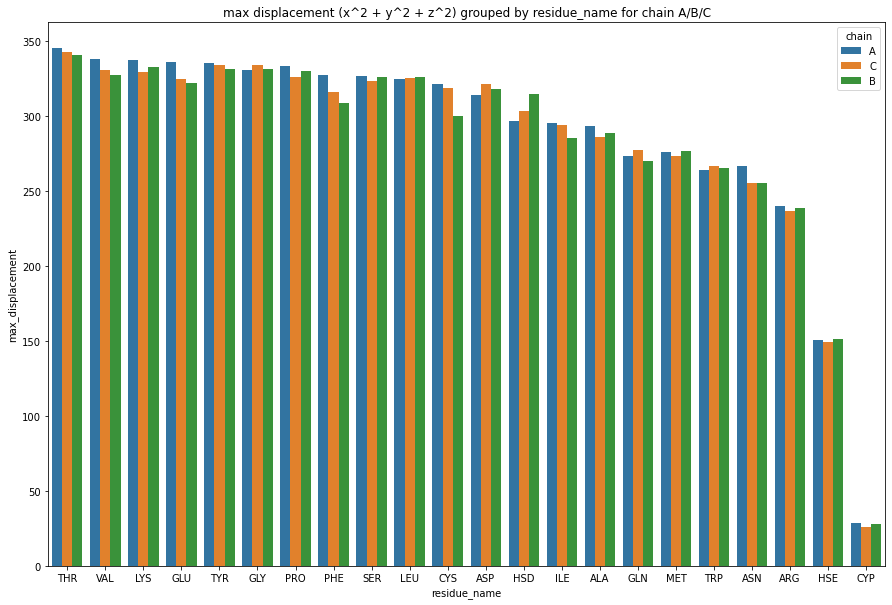

In [564]:
fig, ax = plt.subplots(figsize=(15,10))

sns.barplot(
    data = chain_abc_residue_stats_df,
    x = 'residue_name', y = 'max_displacement', hue ='chain',
    #order = set(chain_abc_residue_stats_df.residue_name.unique()),
    ax = ax
)
ax.set_title('max displacement (x^2 + y^2 + z^2) grouped by residue_name for chain A/B/C')
plt.show()

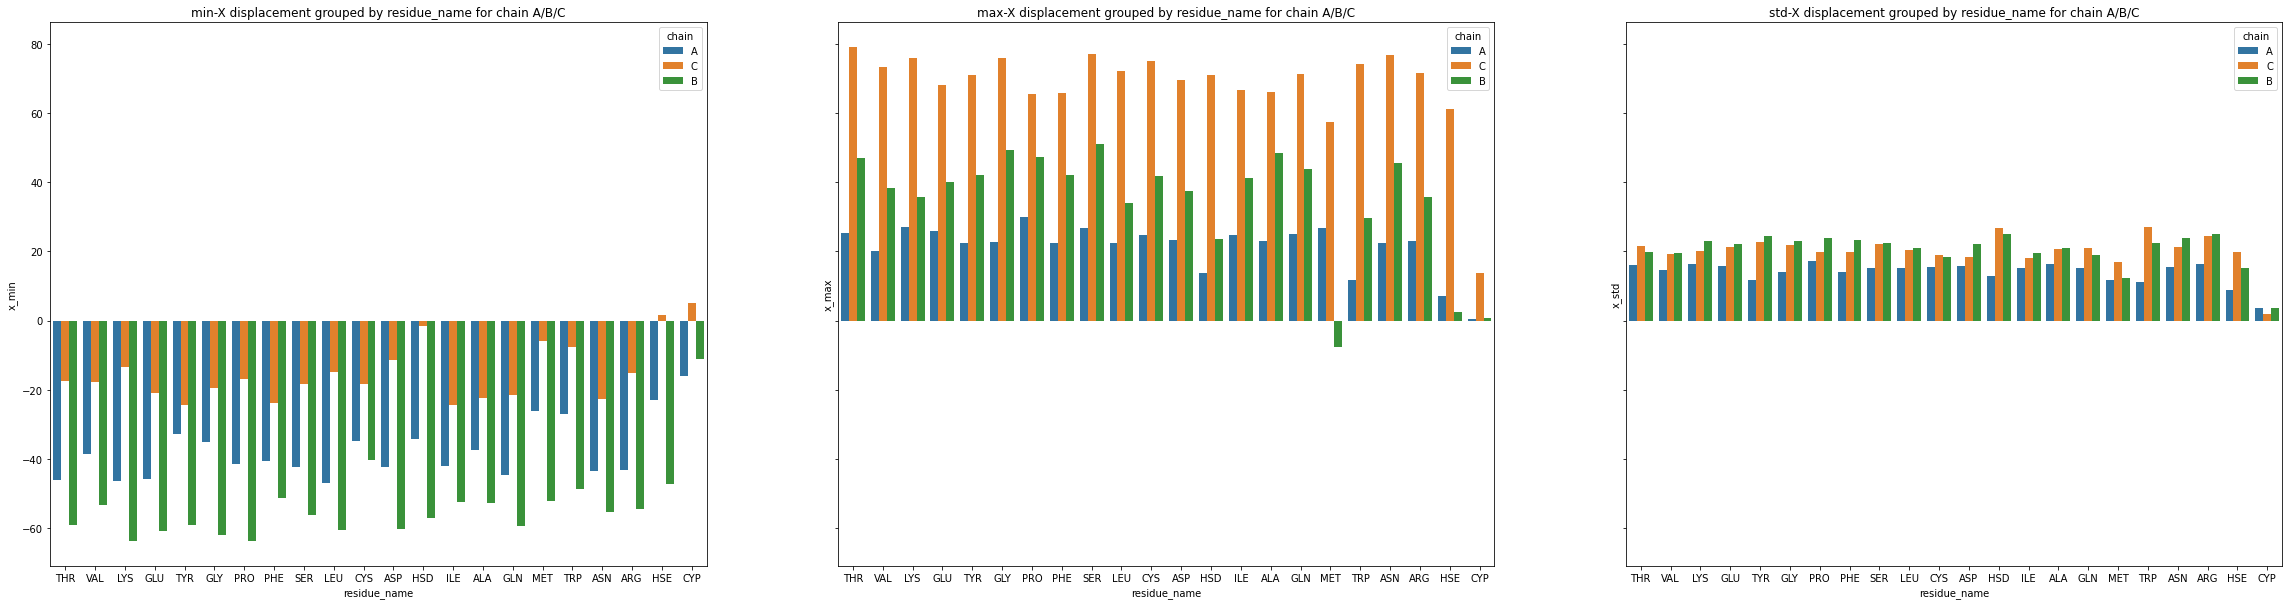

In [480]:
fig, ax = plt.subplots(ncols= 3, figsize=(40,10), sharey = True)

sns.barplot(
    data = chain_abc_residue_stats_df,
    x = 'residue_name', y = 'x_min', hue ='chain',
   # order = set(chain_abc_residue_stats_df.residue_name.unique()),
    ax = ax[0]
)
ax[0].set_title('min-X displacement grouped by residue_name for chain A/B/C')

sns.barplot(
    data = chain_abc_residue_stats_df,
    x = 'residue_name', y = 'x_max', hue ='chain',
   # order = set(chain_abc_residue_stats_df.residue_name.unique()),
    ax = ax[1]
)
ax[1].set_title('max-X displacement grouped by residue_name for chain A/B/C')

sns.barplot(
    data = chain_abc_residue_stats_df,
    x = 'residue_name', y = 'x_std', hue ='chain',
   # order = set(chain_abc_residue_stats_df.residue_name.unique()),
    ax = ax[2]
)
ax[2].set_title('std-X displacement grouped by residue_name for chain A/B/C')
plt.show()

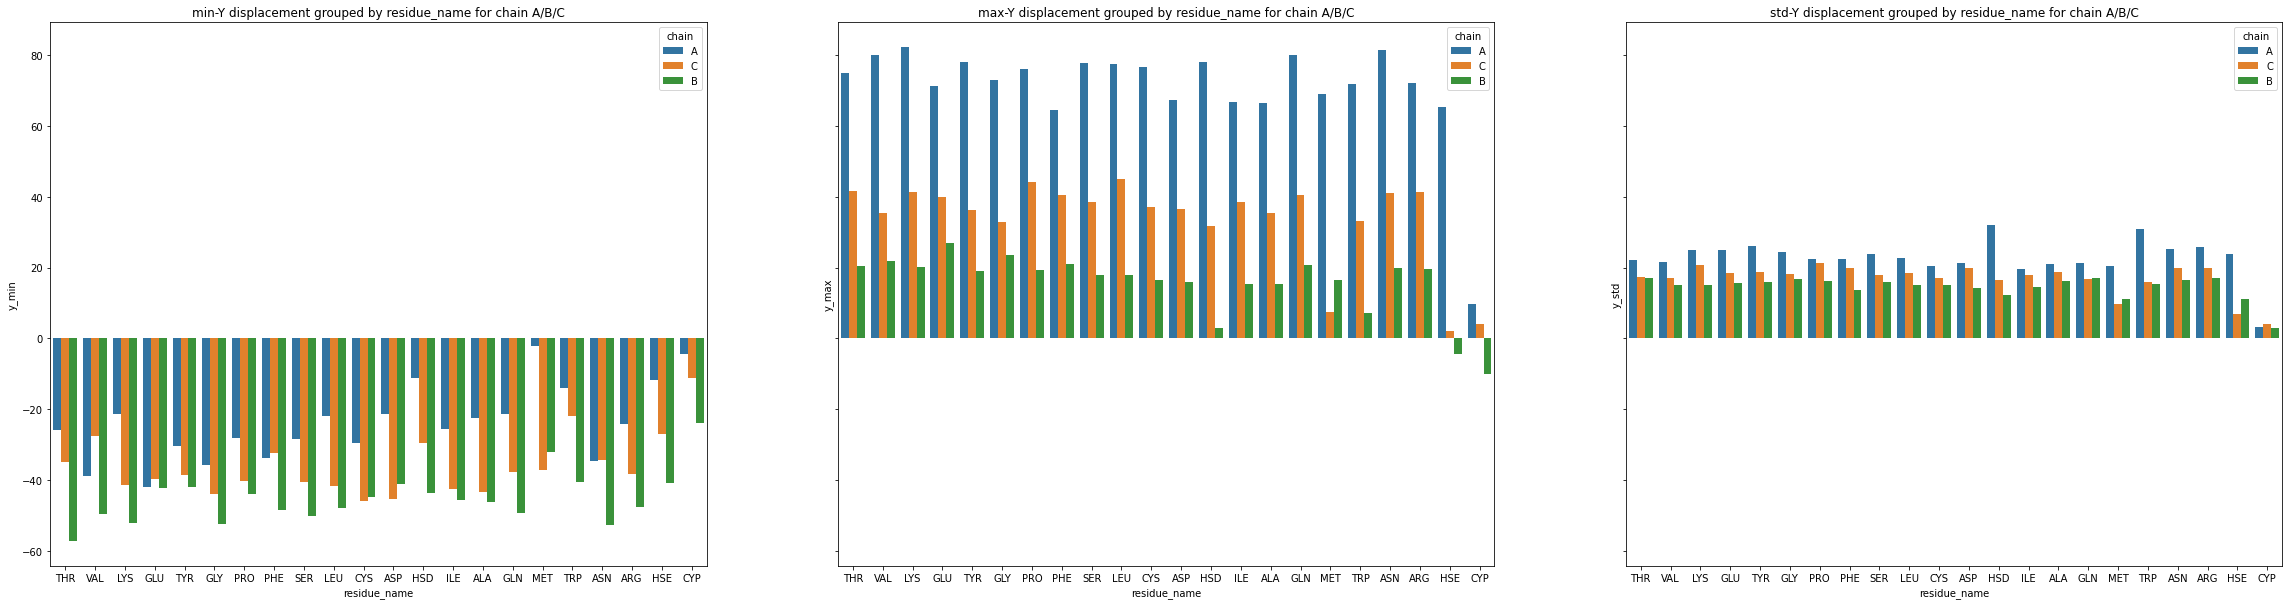

In [481]:
fig, ax = plt.subplots(ncols= 3, figsize=(40,10) , sharey = True)

sns.barplot(
    data = chain_abc_residue_stats_df,
    x = 'residue_name', y = 'y_min', hue ='chain',
   # order = set(chain_abc_residue_stats_df.residue_name.unique()),
    ax = ax[0]
)
ax[0].set_title('min-Y displacement grouped by residue_name for chain A/B/C')

sns.barplot(
    data = chain_abc_residue_stats_df,
    x = 'residue_name', y = 'y_max', hue ='chain',
   # order = set(chain_abc_residue_stats_df.residue_name.unique()),
    ax = ax[1]
)
ax[1].set_title('max-Y displacement grouped by residue_name for chain A/B/C')

sns.barplot(
    data = chain_abc_residue_stats_df,
    x = 'residue_name', y = 'y_std', hue ='chain',
  #  order = set(chain_abc_residue_stats_df.residue_name.unique()),
    ax = ax[2]
)
ax[2].set_title('std-Y displacement grouped by residue_name for chain A/B/C')
plt.show()

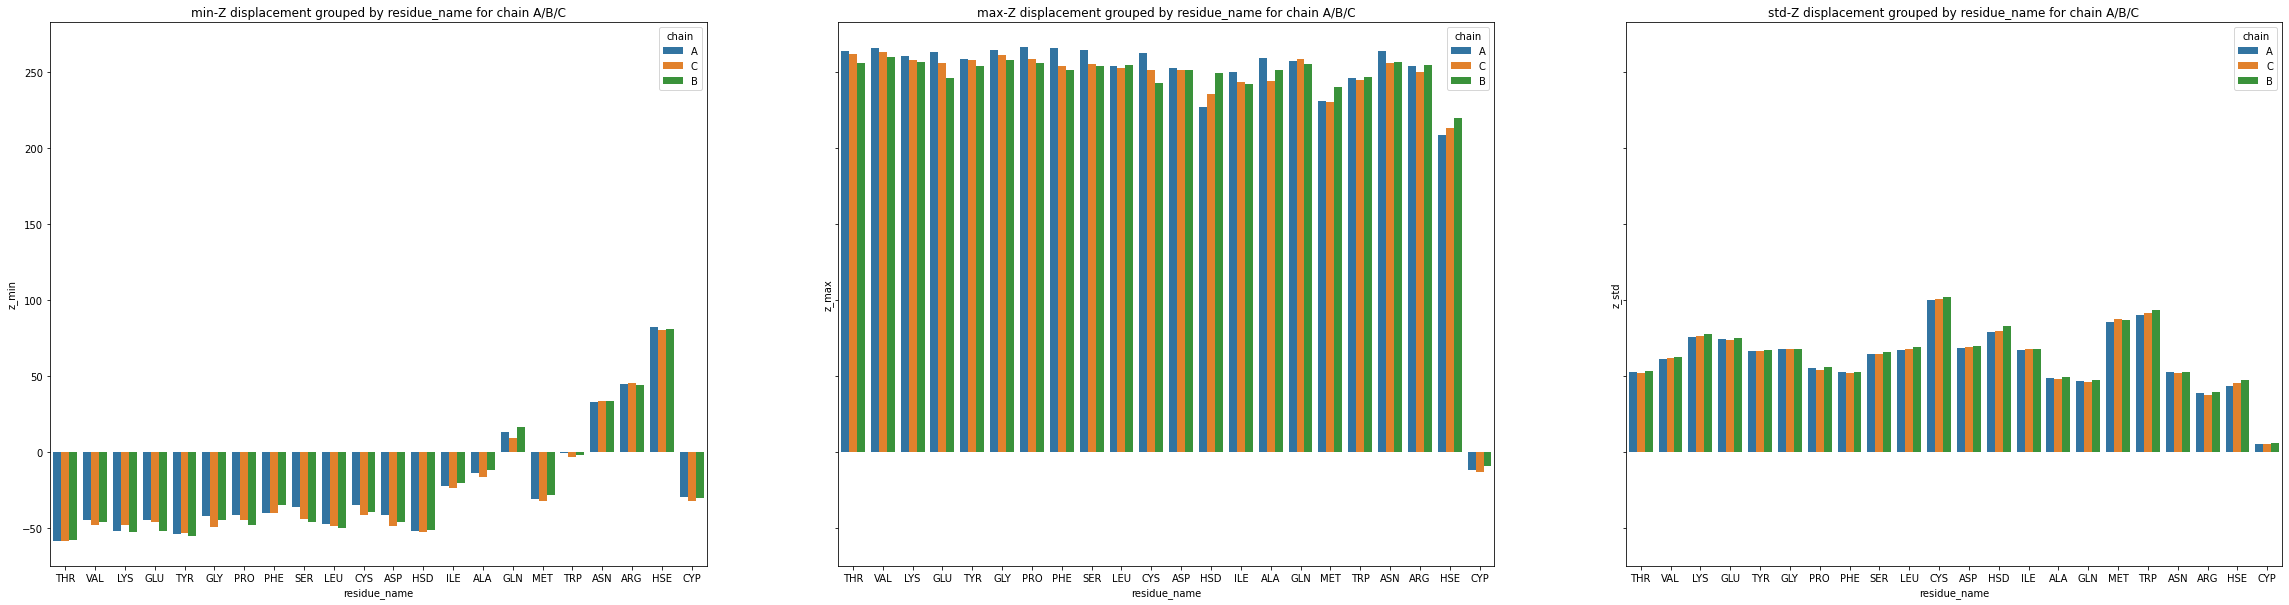

In [482]:
fig, ax = plt.subplots(ncols= 3, figsize=(40,10), sharey = True)

sns.barplot(
    data = chain_abc_residue_stats_df,
    x = 'residue_name', y = 'z_min', hue ='chain',
  #  order = set(chain_abc_residue_stats_df.residue_name.unique()),
    ax = ax[0]
)
ax[0].set_title('min-Z displacement grouped by residue_name for chain A/B/C')

sns.barplot(
    data = chain_abc_residue_stats_df,
    x = 'residue_name', y = 'z_max', hue ='chain',
 #   order = set(chain_abc_residue_stats_df.residue_name.unique()),
    ax = ax[1]
)
ax[1].set_title('max-Z displacement grouped by residue_name for chain A/B/C')

sns.barplot(
    data = chain_abc_residue_stats_df,
    x = 'residue_name', y = 'z_std', hue ='chain',
  #  order = set(chain_abc_residue_stats_df.residue_name.unique()),
    ax = ax[2]
)
ax[2].set_title('std-Z displacement grouped by residue_name for chain A/B/C')
plt.show()

In [405]:
if len(set(pdb_chain_dict_df_pointer['A'].atom_name.unique()).difference(set(pdb_chain_dict_df_pointer['B'].atom_name.unique()))) + len(set(pdb_chain_dict_df_pointer['A'].atom_name.unique()).difference(set(pdb_chain_dict_df_pointer['C'].atom_name.unique())))  == 0:
    print(f'INFO: same set of atom_names across Chain A/B/C')

INFO: same set of atom_names across Chain A/B/C


#### difference in count atoms for THR/CYP across A/B/C chains ??

In [591]:
(pdb_chain_dict_df_pointer['A'][pdb_chain_dict_df_pointer['A'].residue_name == 'THR'].atom_name.value_counts().reset_index().set_index('index').T.reset_index(drop=True).assign(chain ='A').assign(residue = 'THR')
 .append(pdb_chain_dict_df_pointer['B'][pdb_chain_dict_df_pointer['B'].residue_name == 'THR'].atom_name.value_counts().reset_index().set_index('index').T.reset_index(drop=True).assign(chain ='B').assign(residue = 'THR'))
 .append(pdb_chain_dict_df_pointer['C'][pdb_chain_dict_df_pointer['C'].residue_name == 'THR'].atom_name.value_counts().reset_index().set_index('index').T.reset_index(drop=True).assign(chain ='C').assign(residue = 'THR'))
 )

index,N,HN,CA,HA,CB,HB,OG1,CG2,HG21,HG22,HG23,C,HG1,O,OT1,OT2,chain,residue
0,97,97,97,97,97,97,97,97,97,97,97,97,96,96,1,1,A,THR
0,97,97,97,97,97,97,97,97,97,97,97,97,96,96,1,1,B,THR
0,97,97,97,97,97,97,97,97,97,97,97,97,96,96,1,1,C,THR


In [592]:
(pdb_chain_dict_df_pointer['A'][pdb_chain_dict_df_pointer['A'].residue_name == 'CYP'].atom_name.value_counts().reset_index().set_index('index').T.reset_index(drop=True).assign(chain ='A').assign(residue = 'CYP')
 .append(pdb_chain_dict_df_pointer['B'][pdb_chain_dict_df_pointer['B'].residue_name == 'CYP'].atom_name.value_counts().reset_index().set_index('index').T.reset_index(drop=True).assign(chain ='B').assign(residue = 'CYP'))
 .append(pdb_chain_dict_df_pointer['C'][pdb_chain_dict_df_pointer['C'].residue_name == 'CYP'].atom_name.value_counts().reset_index().set_index('index').T.reset_index(drop=True).assign(chain ='C').assign(residue = 'CYP'))
 )

index,N,H12A,H8A,H8B,C9,H9A,H9B,C10,H10A,H10B,...,H4B,C5,H5A,H5B,C6,H6A,H6B,H16C,chain,residue
0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,A,CYP
0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,B,CYP
0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,C,CYP
